# Building a Red-Black Tree

In this notebook, we'll walk through how you might build a red-black tree. Remember, we need to follow the red-black tree rules, on top of the binary search tree rules. Our new rules are:

* All nodes have a color
* All nodes have two children (use NULL nodes)
  * All NULL nodes are colored black
* If a node is red, its children must be black
* The root node must be black (optional)
  * We'll go ahead and implement without this for now
* Every path to its descendant NULL nodes must contain the same number of black nodes

### Sketch

Similar to our binary search tree implementation, we will define a class for nodes and a class for the tree itself. The `Node` class will need a couple new attributes. It is no longer enough to only know the children, because we need to ask questions during insertion like, "what color is my parent's sibling?". So we will add a parent link as well as the color.

In [1]:
class Node(object):
    def __init__(self, value, parent, color):
        self.value = value
        self.left = None
        self.right = None
        self.parent = parent
        self.color = color

For the tree, we can start with a mostly empty implementation. But we know we want to always insert nodes with color red, so let's fill in the constructor to insert the root node.

In [3]:
class RedBlackTree(object):
    def __init__(self, root):
        self.root = Node(root, None, 'red')
    
    def insert(self, new_val):
        pass
    
    def search(self, find_val):
        return False

### Insertion

Now how would we design our `insert` implementation? We know from our experience with BSTs how most of it will work. We can re-use that portion and augment it to assign colors and parents.

In [4]:
class RedBlackTree(object):
    def __init__(self, root):
        self.root = Node(root, None, 'red')
        
    def insert(self, new_val):
        self.insert_helper(self.root, new_val)

    def insert_helper(self, current, new_val):
        if current.value < new_val:
            if current.right:
                self.insert_helper(current.right, current, new_val)
            else:
                current.right = Node(new_val, current, 'red')
        else:
            if current.left:
                self.insert_helper(current.left, current, new_val)
            else:
                current.left = Node(new_val, current, 'red')

### Rotations

At this point we are only making a BST, with extra attributes. To make this a red-black tree, we need to add the extra sauce that makes red-black trees awesome. We will sketch out some more code for rebalancing the tree based on the case, and fill them in one at a time.

First, we need to change our `insert_helper` to return the node that was inserted so we can interrogate it when rebalancing.

In [5]:
class RedBlackTree(object):
    def __init__(self, root):
        self.root = Node(root, None, 'red')
        
    def insert(self, new_val):
        new_node = self.insert_helper(self.root, new_val)
        self.rebalance(new_node)

    def insert_helper(self, current, new_val):
        if current.value < new_val:
            if current.right:
                return self.insert_helper(current.right, new_val)
            else:
                current.right = Node(new_val, current, 'red')
                return current.right
        else:
            if current.left:
                return self.insert_helper(current.left, new_val)
            else:
                current.left = Node(new_val, current, 'red')
                return current.left
    
    def rebalance(self, node):
        pass

#### Case 1

_We have just inserted the root node_

If we're enforcing that the root must be black, we change its color. We are not enforcing this, so we are all done! Four to go.

In [7]:
def rebalance(node):
    if node.parent == None: 
        return

#### Case 2

_We inserted under a black parent node_

Thinking through this, we can observe the following: We inserted a red node beneath a black node. The new children (the NULL nodes) are black by definition, and our red node _replaced_ a black NULL node. So the number of black nodes for any paths from parents is unchanged. Nothing to do in this case, either.

In [8]:
def rebalance(node):    
    # Case 1
    if node.parent == None:
        return
    # Case 2
    if node.parent.color == 'black':
        return

#### Case 3

_The parent and its sibling of the newly inserted node are both red_

Okay, we're done with free cases. In this specific case, we can flip the color of the parent and its sibling. We know they're both red in this case, which means the grandparent is black. It will also need to flip. At that point we will have a freshly painted red node at the grandparent. At that point, we need to do the same evaluation! If the grandparent turns red, and its sibling is also red, that's case 3 again. Guess what that means! Time for more recursion.

We will define the `grandparent` and `pibling` (a parent's sibling) methods later, for now let's focus on the core logic.

In [24]:
def rebalance(self, node):    
    # Case 1
    if node.parent == None:
        return
    # Case 2
    if node.parent.color == 'black':
        return
    # From here, we know parent's color is red
    # Case 3
    if pibling(node).color == 'red':
        pibling(node).color = 'black'
        node.parent.color = 'black'
        grandparent(node).color = 'red'
        self.rebalance(grandparent(node))

#### Case 4

_The newly inserted node has a red parent, but that parent has a black sibling_

These last cases get more interesting. The criteria above actually govern case 4 and 5. What separates them is if the newly inserted node is on the _inside_ or the _outside_ of the sub tree. We define _inside_ and _outside_ like this:

* inside
  * _EITHER_
     * the new node is a left child of its parent, but its parent is a right child, or
     * the new node is a right child of its parent, but its parent is a left child
* outside
  * the opposite of inside, the new node and its parent are on the same side of the grandparent
  
Case 4 is to handle the _inside_ scenario. In this case, we need to rotate. As we will see, this will not finish balancing the tree, but will now qualify for Case 5.

We rotate against the inside-ness of the new node. If the new node qualifies for case 4, it needs to move into its parent's spot. If it's on the right of the parent, that's a rotate left. If it's on the left of the parent, that's a rotate right.

In [83]:
def rebalance(self, node):    
    # ... omitted cases 1-3 ...
    # Case 4
    gp = grandparent(node)
    if gp.left and node == gp.left.right:
        self.rotate_left(parent(node))
    elif gp.right and node == gp.right.left:
        self.rotate_right(parent(node))
    # TODO: Case 5

To implement `rotate_left` and `rotate_right`, think about what we want to accomplish. We want to take one of the node's children and have it take the place of its parent. The given node will move down to a child of the newly parental node.

In [9]:
def rotate_left(self, node):
    # Save off the parent of the sub-tree we're rotating
    p = node.parent

    node_moving_up = node.right
    # After 'node' moves up, the right child will now be a left child
    node.right = node_moving_up.left
    
    # 'node' moves down, to being a left child
    node_moving_up.left = node
    node.parent = node_moving_up
    
    # Now we need to connect to the sub-tree's parent
    # 'node' may have been the root
    if p != None:
        if node == p.left:
            p.left = node_moving_up
        else:
            p.right = node_moving_up
    node_moving_up.parent = p

def rotate_right(self, node):
    p = node.parent

    node_moving_up = node.left
    node.left = node_moving_up.right
    
    node_moving_up.right = node
    node.parent = node_moving_up
    
    # Now we need to connect to the sub-tree's parent
    if p != None:
        if node == p.left:
            p.left = node_moving_up
        else:
            p.right = node_moving_up
    node_moving_up.parent = p
    

#### Case 5

Now that case 4 is resolved, or if we didn't qualify for case 4 and have an outside sub-tree already, we need to rotate again. If our new node is a left child of a left child, we rotate right. If our new node is a right of a right, we rotate left. This is done on the grandparent node.

But after this rotation, our colors will be off. Remember that for cases 3, 4, and 5, the parent of the new node is red. But we will have rotated a red node with a red child up, which violates our rule of all red nodes having two black children. So after rotating, we switch the colors of the (original) parent and grandparent nodes.

In [10]:
def rebalance(self, node):    
    # ... omitted cases 1-3 ...
    # Case 4
    gp = grandparent(node)
    if node == gp.left.right:
        self.rotate_left(node.parent)
    elif node == gp.right.left:
        self.rotate_right(node.parent)

    # Case 5
    p = node.parent
    gp = p.parent
    if node == p.left:
        self.rotate_right(gp)
    else:
        self.rotate_left(gp)
    p.color = 'black'
    gp.color = 'red'


### Result

Combining all of our efforts we have the following.

In [11]:
class Node(object):
    def __init__(self, value, parent, color):
        self.value = value
        self.left = None
        self.right = None
        self.parent = parent
        self.color = color
        
    def __repr__(self):
        print_color = 'R' if self.color == 'red' else 'B'
        return '%d%s' % (self.value, print_color)

def grandparent(node):
    if node.parent == None:
        return None
    return node.parent.parent

# Helper for finding the node's parent's sibling
def pibling(node):
    p = node.parent
    gp = grandparent(node)
    if gp == None:
        return None
    if p == gp.left:
        return gp.right
    if p == gp.right:
        return gp.left

class RedBlackTree(object):
    def __init__(self, root):
        self.root = Node(root, None, 'red')
        
    def __iter__(self):
        yield from self.root.__iter__()
        
    def insert(self, new_val):
        new_node = self.insert_helper(self.root, new_val)
        self.rebalance(new_node)

    def insert_helper(self, current, new_val):
        if current.value < new_val:
            if current.right:
                return self.insert_helper(current.right, new_val)
            else:
                current.right = Node(new_val, current, 'red')
                return current.right
        else:
            if current.left:
                return self.insert_helper(current.left, new_val)
            else:
                current.left = Node(new_val, current, 'red')
                return current.left

    def rebalance(self, node):    
        # Case 1
        if node.parent == None:
            return
        
        # Case 2
        if node.parent.color == 'black':
            return
        
        # Case 3
        if pibling(node) and pibling(node).color == 'red':
            pibling(node).color = 'black'
            node.parent.color = 'black'
            grandparent(node).color = 'red'
            return self.rebalance(grandparent(node))
        
        gp = grandparent(node)        
        # Small change, if there is no grandparent, cases 4 and 5
        # won't apply
        if gp == None:
            return
        
        # Case 4
        if gp.left and node == gp.left.right:
            self.rotate_left(node.parent)
            node = node.left
        elif gp.right and node == gp.right.left:
            self.rotate_right(node.parent)
            node = node.right

        # Case 5
        p = node.parent
        gp = p.parent
        if node == p.left:
            self.rotate_right(gp)
        else:
            self.rotate_left(gp)
        p.color = 'black'
        gp.color = 'red'

    def rotate_left(self, node):
        # Save off the parent of the sub-tree we're rotating
        p = node.parent

        node_moving_up = node.right
        # After 'node' moves up, the right child will now be a left child
        node.right = node_moving_up.left

        # 'node' moves down, to being a left child
        node_moving_up.left = node
        node.parent = node_moving_up

        # Now we need to connect to the sub-tree's parent
        # 'node' may have been the root
        if p != None:
            if node == p.left:
                p.left = node_moving_up
            else:
                p.right = node_moving_up
        node_moving_up.parent = p

    def rotate_right(self, node):
        p = node.parent

        node_moving_up = node.left
        node.left = node_moving_up.right

        node_moving_up.right = node
        node.parent = node_moving_up

        # Now we need to connect to the sub-tree's parent
        if p != None:
            if node == p.left:
                p.left = node_moving_up
            else:
                p.right = node_moving_up
        node_moving_up.parent = p

### Testing

We've written a lot of code. Let's see how the tree mutates as we add nodes.

First, we'll need a way to visualize the tree. The below will nest, but remember the first child is always the left child.

In [4]:
def print_tree(node, level=0):
    print('   ' * (level - 1) + '+--' * (level > 0) + '%s' % node)
    if node.left:
        print_tree(node.left, level + 1)
    if node.right:
        print_tree(node.right, level + 1)

For cases 1 and 2, we can insert the first few nodes and see the tree behaves the same as a BST.

In [13]:
tree = RedBlackTree(9)
tree.insert(6)
tree.insert(19)

print_tree(tree.root)

9R
+--6R
+--19R


Inserting 13 should flip 6 and 19 to black, as it hits our Case 3 logic.

In [14]:
tree.insert(13)
print_tree(tree.root)

9R
+--6B
+--19B
   +--13R


Observe that 13 was inserted as red, and then because of Case 3, 6 and 19 flipped to black. 9 was also assigned red, but that was not a net change. Because we're not enforcing the optional "root is always black rule", this is acceptable.

Now let's cause some rotations. When we insert 16, it goes under 13, but 13 does not have a red sibling. 16 rotates into 13's spot, because it's currently an _inside_ sub-tree. Then 16 rotates into 19's spot. After these rotations, the ordering of the BST has been preserved _and_ our tree is balanced.

In [15]:
tree.insert(16)
print_tree(tree.root)

9R
+--6B
+--16B
   +--13R
   +--19R


# 👏👏👏👏👏

You've done it! Go ahead and pat yourself on the back! This is a complex use of a data structure that has significant power. It uses _O(n)_ space and insertions and search perform in _O(log n)_ time.

## Further Exercises

To continue exploring our red-black tree implementation, you might try the following.
* Observe that our current implementation will add duplicates of the same value. Is that desirable? How would you expect that to behave? Change the implementation to mark how many times the same value has been inserted.
* Implement search and see how it remains logarithmic for large data sets
* Tinker with the rotations and early escapes to see how they break (use `print_tree`)
* Consider adding deletion or sketching out how it should work

## Practice

My implementation of red-black tree with insert functionality, based on learnings from MIT lecture on the same: https://www.youtube.com/watch?v=O3hI9FdxFOM. Implementation-wise, Udacity's solution doesn't ensure that root is kept black, whereas I'm adhering to the lecuture, according to which root must be kept black. 

I've also added duplicate counting as well as search funcionality as suggested in 'Further Exercises'.

NOTE: I forgot to update the parent pointers while moving nodes around during rotation. So, I defined setter function for the class Node, that automatically updates parent pointer of the child node being set. In this regard, think there are some bugs in Udacity's solution, they are not setting the parent pointer of child being transfered during rotate operation correctly.

In [17]:
def get_grandparent(node):
    '''
    Get grandparent of node
    '''
    if node:
        parent = node.parent
        if parent:
            return parent.parent
    return None # not necessary, function by default returns None, but just adding here for clarity

def get_pibling(node):
    '''
    Get node's parent's sibling
    '''
    gp = get_grandparent(node)
    if gp:
        if gp.left == node.parent:
            return gp.right
        else:
            return gp.left
        

In [34]:
class Node:
    def __init__(self, value, parent, color):
        self.value = value
        self.left = None
        self.right = None
        self.parent = parent
        self.color = color
        self.num_duplicates = 0
        
    def set_left_child(self, left):
        self.left = left
        if left is not None:
            left.parent = self
        
    def set_right_child(self, right):
        self.right = right
        if right is not None:
            right.parent = self
        
    def __repr__(self):
        print_color = 'R' if self.color == 'red' else 'B'
        return f"{self.value}{print_color}"
        
class RedBlackTree:
    def __init__(self, value):
        self.root = Node(value, None, 'black')
        
    def _insert_helper(self, node, new_value):
        '''
        Inserts new value in the subtree rooted at node, and returns the inserted node
        '''
        if new_value < node.value:
            if node.left is not None:
                return self._insert_helper(node.left, new_value)
            else:
                node.set_left_child(Node(new_value, node, 'red'))
                return node.left
        elif new_value > node.value:
            if node.right is not None:
                return self._insert_helper(node.right, new_value)
            else:
                node.set_right_child(Node(new_value, node, 'red'))
                return node.right
        else: # in case value is equal to current, do nothing
            node.num_duplicates += 1
            return node
            
    def insert(self, new_value):
        if self.root is None:
            self.root = Node(new_value, None, 'black')
            return
        
        inserted_node = self._insert_helper(self.root, new_value)
        self.rebalance(inserted_node)
        self.root.color = 'black'
        
        
    def _search_helper(self, node, find_value):
        if node is None:
            return False
        
        if find_value < node.value:
            return self._search_helper(node.left, find_value)
        elif find_value > node.value:
            return self._search_helper(node.right, find_value)
        else:
            return True
                
    def search(self, find_value):
        return self._search_helper(self.root, find_value)
    
    def rotate_left(self, pivot):
        '''
        Rotate left about pivot and connect the new node in pivot's position, to the parent of subtree centered at pivot
        '''
        # saving parent of pivot, to be used later to connect the node that replaces pivot to pivot's parent
        parent = pivot.parent
        right_child = pivot.right
        
        pivot.set_right_child(right_child.left)
        right_child.set_left_child(pivot)
        
        # promote right child up, to pivot's position
        if parent is None: # parent would have been none if pivot were root
            right_child.parent = None # now, right_child is root
            self.root = right_child
        else:
            if pivot == parent.left:
                parent.set_left_child(right_child)
            else:
                parent.set_right_child(right_child)
        
    def rotate_right(self, pivot):
        '''
        Rotate left about pivot and connect the new node in pivot's position, to the parent of subtree centered at pivot
        '''
         # saving parent of pivot, to be used later to connect the node that replaces pivot to pivot's parent
        parent = pivot.parent
        left_child = pivot.left
        
        pivot.set_left_child(left_child.right)
        left_child.set_right_child(pivot)
        
        # promote right child up, to pivot's position
        if parent is None: # parent would have been none if pivot were root
            left_child.parent = None # now, left_child is root
            self.root = left_child
        else:
            if pivot == parent.left:
                parent.set_left_child(left_child)
            else:
                parent.set_right_child(left_child)
        
    def rebalance(self, node):
        '''
        Rebalance the tree after inserting node
        '''
        if node.parent is None: # node is root
            return 
        
        if node.parent.color == 'black': # nothing to be done
            return
        
        pibling = get_pibling(node)
        gp = get_grandparent(node)
        
        # if there's no grandparent, following cases won't apply
        if gp is None:
            return
        
        if pibling and pibling.color == 'red': # requires only re-coloring
            gp.color = 'red'
            pibling.color = 'black'
            node.parent.color = 'black'
            self.rebalance(gp)
        else: # pibling is black or NIL (external black node), requires rotations (at max 2, then, tree is fixed for good)
            
            # case 1: if left-right, rotate left, rotate right, recolor
            # case 2: if right-left, rotate right, rotate left, recolor (symmetric opposite of case 1)
            # case 3: if left-left, rotate right, recolor
            # case 4: id right-right, rotate left, recolor (symmetric oppostie of case 3)
            
            p = node.parent
            if p == gp.left:
                if node == p.right: # case 1
                    self.rotate_left(p)   
                # case 3 (and second part of case 1)
                self.rotate_right(gp)

            else:
                if node == p.left: # case 2
                    self.rotate_right(p)
                    
                # case 4 (and second part of case 2)
                self.rotate_left(gp)
                
            # recolor
            gp.color = 'red'
            gp.parent.color = 'black'
            
    def _print_helper(self, node, which_child='', level=0):
        print('   ' * (level - 1) + '+--' * (level > 0) + which_child + '%s' % node)
        if node.left:
            self._print_helper(node.left, 'left ', level + 1)
        if node.right:
            self._print_helper(node.right, 'right ', level + 1)
            
    def _print(self):
        '''
        Prints tree, same as print_tree(), but I've added the information of left/right child, for ease of debugging
        '''
        self._print_helper(self.root)

In [19]:
# Incremental testing

# # node creation
# A = Node(9, None, 'red')
# A

# # tree initialization
# T = RedBlackTree(10)
# T.root

# # BST insert, i.e. with self.balance()  line commented out from self.insert() in RedBlackTree definition
# tree = RedBlackTree(9)
# tree.insert(6)
# tree.insert(19)
# tree.insert(13)
# tree.insert(16)

# print('Original Tree: ')
# tree._print()

# # rotation
# probe = tree.root.right.left
# print('Probe: %s' % probe) # should print 13R

# print('\nLeft Rotated Tree: ')
# tree.rotate_left(probe)
# tree._print()

# probe = tree.root.right
# print('\nProbe: %s' % probe) # should print 19R

# print('\nRight Rotated Tree: ')
# tree.rotate_right(probe)
# tree._print()

# red-black tree insert
tree = RedBlackTree(9)
tree.insert(6)
tree.insert(19)
tree._print()

9B
+--left 6R
+--right 19R


In [20]:
tree.insert(13)
tree._print()

9B
+--left 6B
+--right 19B
   +--left 13R


In [21]:
tree.insert(16)
tree._print()

9B
+--left 6B
+--right 16B
   +--left 13R
   +--right 19R


Awesome! Insert works!

In [22]:
## testing duplicate counting - works!
print(tree.root.right.num_duplicates)

tree.insert(16)
tree._print()

print(tree.root.right.num_duplicates)

0
9B
+--left 6B
+--right 16B
   +--left 13R
   +--right 19R
1


In [23]:
# testing search
print(tree.search(6))
print(tree.search(19))
print(tree.search(5))

True
True
False


[]

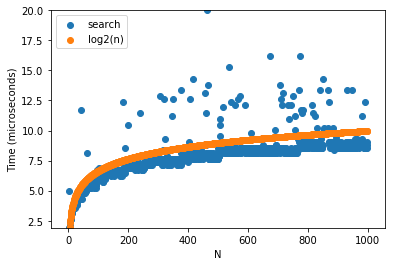

In [66]:
# verifying if search remains logarithmic for large datasets

import matplotlib.pyplot as plt
import time
import numpy as np
%matplotlib inline

times = []
big_array = range(10, 10000, 10)
for idx, element in enumerate(big_array):
    if idx == 0:
        T = RedBlackTree(element)
    else:
        T.insert(element)
    
    # searching for the most recently inserted element, to ensure that much of the height is
    # traversed. If the tree is constructed right, it should take O(logn) time to search.
    start_time = time.time()
    _ = T.search(element)
    times.append((time.time() - start_time)*1e6) 
    
x = range(1, len(big_array)+1)
y = np.log2(x)
plt.scatter(x, times, label="search")
plt.scatter(x, y, label="log2(n)")
# plt.ylim(top=max(times), bottom=min(times))
plt.ylim(top=20., bottom=min(times)) # clipping at 20 microseconds to get rid of some outliers
plt.xlabel('N')
plt.ylabel('Time (microseconds)')
plt.legend(loc="upper left")
plt.plot()

As, can be seen the logarihmic shape of the curve is very clearly visible, plotting log2(n) for shape comparison. Similarity, in shape suggests, search operation stays logarithmic even for large datasets.